## Latent Factorized Collaborative Filter with Mini-Batch SGD on Amazon Beauty Product 

In [1]:
import copy
import os
import pandas as pd
import math
import gzip
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns; sns.set(style="white", color_codes=True)
import json
from sklearn.metrics import mean_squared_error
%matplotlib inline

### Read In Data

In [2]:
def parse(path):
    g = open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

df_original = getDF('Beauty_5.json')

In [7]:
df_original.head()

,reviewerID,asin,reviewerName,unixReviewTime,summary,overall,helpful,reviewTime,reviewText
0,A1YJEY40YUW4SE,7806397051,Andrea,1391040000,Don't waste your money,1.0,"[3, 4]","01 30, 2014",Very oily and creamy. Not at all what I expect...
1,A60XNB876KYML,7806397051,Jessica H.,1397779200,OK Palette!,3.0,"[1, 1]","04 18, 2014",This palette was a decent price and I was look...
2,A3G6XNM240RMWA,7806397051,Karen,1378425600,great quality,4.0,"[0, 1]","09 6, 2013",The texture of this concealer pallet is fantas...
3,A1PQFP6SAJ6D80,7806397051,Norah,1386460800,Do not work on my face,2.0,"[2, 2]","12 8, 2013",I really can't tell what exactly this thing is...
4,A38FVHZTNQ271F,7806397051,Nova Amor,1382140800,It's okay.,3.0,"[0, 0]","10 19, 2013","It was a little smaller than I expected, but t..."


In [3]:
df=copy.deepcopy(df_original)
df['unixReviewTime']=pd.to_datetime(df['unixReviewTime'],unit='s')
df.drop(['reviewTime'],axis=1,inplace=True)
# set unique ID for each review
df['ReviewID']=df.index+1

### Check Distribution of Ratings

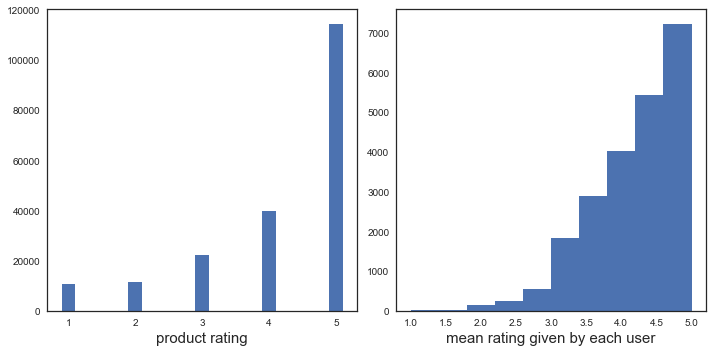

In [9]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
ax.hist(df['overall'], bins=[0.9, 1.1, 1.9, 2.1, 2.9, 3.1, 3.9, 4.1, 4.9, 5.1])
ax.set_xlabel('product rating', fontsize=15)

# mean ratings from each user
mean_rating_of_user = df.groupby('reviewerID').apply(lambda x: x['overall'].mean())
ax = fig.add_subplot(122)
ax.hist(mean_rating_of_user)
ax.set_xlabel('mean rating given by each user', fontsize=15)
plt.tight_layout()
plt.show()

The ratings on items are severely left-skewed. Normalization is required both reviewer-wisely and item-wisely when training the models.

### Check Number Of Reviewer and Items

In [4]:
n_users = df.reviewerID.unique().shape[0]
n_items = df.asin.unique().shape[0]
print (str(n_users) + ' users')
print (str(n_items) + ' items')

22363 users
12101 items


### Parse ID to Number

This step maps all asin and revierID in strings to numerical ID, which would be applied as position indexs of the rating matrixs with row as the number of reviewers times the columns as the number of items.

In [5]:
df = df.sort_values(['reviewerID', 'asin'], ascending = [True, True])
df.asin=pd.core.categorical.Categorical(df.asin)
df['asin_id']=df.asin.cat.codes
df.reviewerID=pd.core.categorical.Categorical(df.reviewerID)
df['reviewer_ID']=df.reviewerID.cat.codes

In [6]:
#check for the output of transformation to category
print ("reviewer ",pd.DataFrame(df.groupby(['reviewer_ID'])['reviewerID'].nunique()).sort_values(['reviewerID'],ascending=False).shape[0])
print ("item ", pd.DataFrame(df.groupby(['asin_id'])['asin'].nunique()).sort_values(['asin'],ascending=False).shape[0])

reviewer  22363
item  12101


### Construct User-Item Matrix

In [7]:
df.head()
df_ratings=df[['reviewer_ID','asin_id','overall']]
ratings = np.zeros((n_users, n_items))

for row in df_ratings.itertuples():
    #print (row[1],row[2],row[3])
    ratings[row[1], row[2]] = row[3]
    
ratings

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [8]:
#sparsity check
sparsity = float(len(ratings.nonzero()[0]))
sparsity = (sparsity/(ratings.shape[0] * ratings.shape[1]))*100
print ('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 0.07%


### Check Distribution on Number of Items Rated by Users and Items Rated by Number of Users

In [15]:
min_rated_items=ratings.nonzero()[0]
min_rated_items_collection={}
for i in min_rated_items:
    if i in min_rated_items_collection:
        min_rated_items_collection[i]=min_rated_items_collection[i]+1
    else:
        min_rated_items_collection[i]=1

In [16]:
user_rate_count=sorted(min_rated_items_collection.items(),key=lambda x:x[1])
print ('User rated ',user_rate_count[-1][1], 'items at the most')
print ('User rated ',user_rate_count[0][1], 'items at the least')

User rated  204 items at the most
User rated  5 items at the least


In [17]:
min_rate_by_users=ratings.nonzero()[1]
min_rate_by_users_collection={}
for i in min_rate_by_users:
    if i in min_rate_by_users_collection:
        min_rate_by_users_collection[i]=min_rate_by_users_collection[i]+1
    else:
        min_rate_by_users_collection[i]=1

In [18]:
item_rate_count=sorted(min_rate_by_users_collection.items(),key=lambda x:x[1])
print ('Item rated by ',item_rate_count[-1][1], ' sers at the most')
print ('Item rated by ',item_rate_count[0][1], ' users at the least')

Item rated by  431  sers at the most
Item rated by  5  users at the least


In [19]:
# set-up bins
count_bin=np.linspace(10,100,10).tolist()
count_bin.extend([5,300,500])
array_rate_count=np.array(count_bin)
array_rate_count=np.sort(array_rate_count)

In [20]:
# get the user-rated item number distribution table
def to_category(row,colname='rated_items',cate=array_rate_count):
    first_arg=np.where(cate>=row[colname])[0][0]
    if first_arg!=0:
        return "("+str(int(cate[first_arg-1]))+", "+str(int(cate[first_arg]))+"]", cate[first_arg]
    else:
        return "(, "+str(int(cate[first_arg]))+"]", cate[first_arg]

item_count=pd.DataFrame.from_dict(min_rated_items_collection,orient='index')\
.reset_index().rename(columns={'index':'userID',0: 'rated_items'})
item_count['rated_items_cat'],item_count['rated_items_num']=zip(*item_count\
                                                                .apply(to_category,cate=array_rate_count,axis=1))
pd.DataFrame(item_count.groupby(['rated_items_cat'])['userID'].count()).reset_index()

,rated_items_cat,userID
0,"(, 5]",7162
1,"(10, 20]",3106
2,"(100, 300]",17
3,"(20, 30]",655
4,"(30, 40]",231
5,"(40, 50]",97
6,"(5, 10]",10959
7,"(50, 60]",62
8,"(60, 70]",23
9,"(70, 80]",26


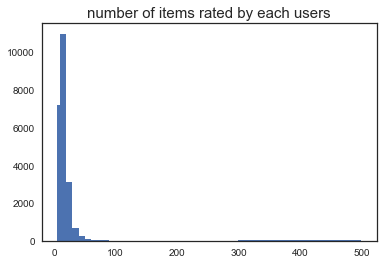

In [21]:
plt.hist(item_count['rated_items_num'],array_rate_count)
plt.title('number of items rated by each users', fontsize=15)
plt.show()

In [22]:
# get the item rated by the number of users distribution table
user_count=pd.DataFrame.from_dict(min_rate_by_users_collection,orient='index')\
.reset_index().rename(columns={'index':'itemID',0: 'rated_by_users'})
user_count['rated_by_user_cat'],user_count['rated_by_user_num']=zip(*user_count.apply(to_category,colname='rated_by_users',cate=array_rate_count,axis=1))
pd.DataFrame(user_count.groupby(['rated_by_user_cat'])['itemID'].count()).reset_index()

,rated_by_user_cat,itemID
0,"(, 5]",2181
1,"(10, 20]",2632
2,"(100, 300]",159
3,"(20, 30]",870
4,"(30, 40]",422
5,"(300, 500]",10
6,"(40, 50]",240
7,"(5, 10]",5031
8,"(50, 60]",181
9,"(60, 70]",138


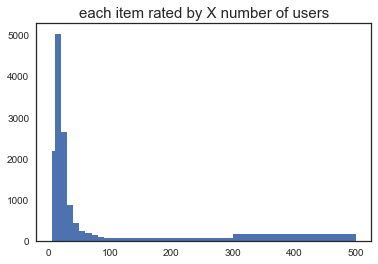

In [23]:
plt.hist(user_count['rated_by_user_num'],array_rate_count)
plt.title('each item rated by X number of users', fontsize=15)
plt.show()

### Reduce Sparsity With N-Core

32% users rated only 5 items and 49% users rated 6 to 10 items. In this notebook, 8 is selected as the threshold for the items and users, i.e. each user should rated at least 8 items and each item should be rated by at least 8 users. Meanwhile, the map between the position index before and after the N-core transformaiton are kept to ensure the traceability of prediction result later.

In [8]:
# modify N-core to add the map between new position to old position
def apply_Ncore(ratings, N_core):
    n_users = ratings.shape[0]
    n_items = ratings.shape[1]
    items_id = [x for x in range(n_items) if len(ratings[:, x].nonzero()[0]) >= N_core]
    ratings = ratings[:, items_id]
    # map the new items position to the old
    item_link=list(zip(items_id,range(ratings.shape[1])))
    users_id = [x for x in range(n_users) if len(ratings[x, :].nonzero()[0]) >= N_core]
    # map the new user posistion to the old
    ratings = ratings[users_id, :]
    user_link=list(zip(users_id,range(ratings.shape[0])))
    return ratings,item_link,user_link

In [9]:
ratings_Ncore,items_link_Ncore,users_link_Ncore = apply_Ncore(ratings, 8)

In [10]:
print("After applying the 10-core, there are", ratings_Ncore.shape[0], "users left")
print("After applying the 10-core, there are", ratings_Ncore.shape[1], "items left")
sparsity = float(len(ratings_Ncore.nonzero()[0]))
sparsity = (sparsity/(ratings_Ncore.shape[0] * ratings_Ncore.shape[1]))*100
print ('Sparsity: {:4.2f}%'.format(sparsity))

After applying the 10-core, there are 6172 users left
After applying the 10-core, there are 7129 items left
Sparsity: 0.20%


### Map User/Item Position Back To asin (item ID) and reviewerID (user ID)

In [11]:
df.head()

,overall,helpful,summary,reviewerID,asin,unixReviewTime,reviewerName,reviewText,ReviewID,asin_id,reviewer_ID
145572,3.0,"[0, 0]",Three Stars,A00414041RD0BXM6WK0GX,B007IY97U0,2014-07-14,Sarah Hale,"Good quality wig, but the blonde is much more ...",145573,9449,0
152551,2.0,"[0, 0]",( After waiting over a month to receive this w...,A00414041RD0BXM6WK0GX,B00870XLDS,2014-07-14,Sarah Hale,Very thin and not as long as the photos :( Aft...,152552,9839,0
155883,1.0,"[0, 0]",( After waiting over a month to receive this w...,A00414041RD0BXM6WK0GX,B008MIRO88,2014-07-14,Sarah Hale,Very thin and not as long as the photos :( Aft...,155884,10076,0
178477,3.0,"[0, 0]",This is a great quality wig,A00414041RD0BXM6WK0GX,B00BQYYMN0,2014-07-14,Sarah Hale,"This is a great quality wig, however it is a m...",178478,11155,0
188781,5.0,"[0, 0]",This is my absolute favorite wig! I have purch...,A00414041RD0BXM6WK0GX,B00GRTQBTM,2014-07-14,Sarah Hale,This is my absolute favorite wig! I have purch...,188782,11752,0


In [11]:
df['reviewerID_Ncore']=df['reviewer_ID'].map(dict(users_link_Ncore))
df['asinID_Ncore']=df['asin_id'].map(dict(items_link_Ncore))
item_map_afterNcore=df[['asinID_Ncore','asin']].drop_duplicates(keep='first')
user_map_afterNcore=df[['reviewerID_Ncore','reviewerID']].drop_duplicates(keep='first')

In [12]:
user_map_afterNcore.loc[user_map_afterNcore['reviewerID_Ncore']==1]

,reviewerID_Ncore,reviewerID
22693,1.0,A03364251DGXSGA9PSR99


In [33]:
#check for whether the item id is linked back correctly to asin
df.loc[df['reviewerID']=='A099766128UI0NCS98N1E',['reviewerID','asin','reviewer_ID','reviewerID_Ncore','asin_id','asinID_Ncore']]

,reviewerID,asin,reviewer_ID,reviewerID_Ncore,asin_id,asinID_Ncore
3539,A099766128UI0NCS98N1E,B00008MOQE,29,4.0,184,123.0
6806,A099766128UI0NCS98N1E,B0001TOH8G,29,4.0,359,237.0
11638,A099766128UI0NCS98N1E,B0007W1R58,29,4.0,687,440.0
42136,A099766128UI0NCS98N1E,B0012UEJ1S,29,4.0,2846,1644.0
66990,A099766128UI0NCS98N1E,B001YTD3G4,29,4.0,4562,2622.0
92722,A099766128UI0NCS98N1E,B003OIPJZ6,29,4.0,6250,3599.0
93742,A099766128UI0NCS98N1E,B003RF82UK,29,4.0,6310,3636.0
103137,A099766128UI0NCS98N1E,B0048KSGZO,29,4.0,6902,4001.0
103757,A099766128UI0NCS98N1E,B004AGM47C,29,4.0,6943,NaN
104465,A099766128UI0NCS98N1E,B004BCX8B6,29,4.0,6992,4056.0


### Split into Training and Test 

Different from other entry-wise training test spliting, we split the data set by poping out N items bought by each users in the 8-core matrix into a test set and keep the rest in the training set. This training-test split increased the sparsity of the training set.

In [13]:
def train_test_split_userwise(ratings,num_test=5):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    nonzero_id=np.transpose(np.array([ratings.nonzero()[0].tolist(),ratings.nonzero()[1].tolist()]))
    index=pd.DataFrame(nonzero_id,columns=['row','col'])
    gps =index.groupby(['row'])
    randx = lambda obj: obj.loc[np.random.choice(obj.index, num_test, False),:]
    test_ratings=gps.apply(randx).values.transpose()
    test_ratings_row=test_ratings[0].tolist()
    test_ratings_col=test_ratings[1].tolist()
    train[test_ratings_row,test_ratings_col] = 0.
    test[test_ratings_row,test_ratings_col] = ratings[test_ratings_row,test_ratings_col]   
    assert(np.all((train * test) == 0)) 
    return train, test

In [14]:
train_Ncore_user, test_Ncore_user = train_test_split_userwise(ratings_Ncore,num_test=3)
# check whether the test dataset has the same shape as the training
print('training_dimension: ', train_Ncore_user.shape)
print('test dimension: ',test_Ncore_user.shape)

training_dimension:  (6172, 7129)
test dimension:  (6172, 7129)


### Normalization

Each user has his/her bias on ratings. Some users tend to give an average rating higher than 3 while others might give an average lower than 3, vice versus for the item rated by users. Thus, the traing and test sets need be normalized if there is no user or item bias adjustment terms in the modeling class. Later on, at the stage of comparing the predicted ratings with the test set and calculate the Mean Square Errors, we should also subtract the normalized test set values from the prediciton trained by normalized training set and deduct the original test set ratings fom the prediction trained based on the training set without normalization.

In [23]:
#user-wise
def normalize_userwise(train,test):
    user=0
    train_new=copy.deepcopy(train)
    test_new=copy.deepcopy(test)
    for i in range(train_new.shape[0]):
        items=np.nonzero(train_new[i,:])[0].tolist()
        user_avg=np.sum(train_new[i,items])/len(items)
        items_test=np.nonzero(test_new[i,:])[0].tolist()
        train_new[i,items]=(train_new[i,items]-user_avg)
        test_new[i,items_test]=(test_new[i,items_test]-user_avg)
    return train_new, test_new
        

In [24]:
train_Ncore_user_normalized,test_Ncore_user_normalized=normalize_userwise(train_Ncore_user,test_Ncore_user)

In [30]:
# check for the output of normaization
# user for 0 in training set
user_0_trainting_sum=np.sum(train_Ncore_user_normalized[1,[x[1] for x in \
                                       list(zip(np.nonzero(train_Ncore_user_normalized)[0],\
                                            np.nonzero(train_Ncore_user_normalized)[1])) if x[0]==1]])
print ('average ratings for user 0 in training after normalization: ', user_0_trainting_sum)

# user for 0 in test set
user_0_test_sum=np.sum(test_Ncore_user_normalized[1,[x[1] for x in \
                                       list(zip(np.nonzero(test_Ncore_user_normalized)[0],\
                                            np.nonzero(test_Ncore_user_normalized)[1])) if x[0]==1]])
print ('average ratings for user 0 in test after normalization: ',user_0_test_sum)

average ratings for user 0 in training after normalization:  1.7763568394e-15
average ratings for user 0 in test after normalization:  2.3


### Baseline MSE

Before statring training a collaborative filter, we must set a baseline MSE as a flag to compare with. In this notebook, we are going to compute the average ratings on items given by each users in the training set and normalized the non-zero ratings in the test set by subtracting the mean. The Mean Square Error of the normalized test set is the baseline.

In [15]:
def get_mse(pred, actual):
    pred = pred[actual.nonzero()[0].tolist(),actual.nonzero()[1].tolist()].flatten()
    actual = actual[actual.nonzero()[0].tolist(),actual.nonzero()[1].tolist()].flatten()
    mse = mean_squared_error(pred, actual)
    return mse

In [16]:
#baseline
def user_baseline(train,test):
    user=0
    item_sum=0
    item_count=0
    pred=np.zeros(test.shape)
    for i in zip(np.nonzero(train)[0],np.nonzero(train)[1]):
        if i[0]==user:
            item_sum=train[i[0],i[1]]+item_sum
            item_count=item_count+1
        if i[0]>user:
            item_pos=np.nonzero(test[user,:])[0].tolist()
            pred[user,item_pos]=item_sum/item_count
            user=user+1
            item_sum=0
            item_count=0
            item_sum=train[i[0],i[1]]+item_sum
            item_count=item_count+1
    item_pos=np.nonzero(test[user,:])[0].tolist()
    pred[user,item_pos]=item_sum/item_count
    return pred

In [17]:
# baseline without normalization
# baseline MSE for Stochastic Gradient Descent
user_baseline_withoutN=user_baseline(train_Ncore_user,test_Ncore_user)
print ('baseline MSE without normalization: ', get_mse(user_baseline_withoutN,test_Ncore_user))

baseline MSE without normalization:  1.21528380265


In [25]:
# baseline with normalization
# baseline MSE for Alternating Least Square
user_baseline_normalized=np.sum(test_Ncore_user_normalized**2)/len(np.nonzero(test_Ncore_user)[0])
print ('baseline MSE with normalization: ', user_baseline_normalized)

baseline MSE with normalization:  1.20416387883


The two baseline MSE are completely same because the two normalization processes above are basically the same: when calculating the MSE without normalization, we first compute the predicted ratings in test by replacing all non-zero values in the matrix with the user-wise average of the training set, and then sum up the square difference between the actual test set and the predicted test ratings and divide the output by the number of non-zero valus in the 8-core matrix (matrix not normalized); when calculating the MSE based on normalized test set, we simply sum up the square of test set normalized by the user-wise mean in training set and divide the total number of non-zero values in the test set (8-core before normalization) as well

### Latent Factorized Collaborative Filter By Alternating Least Square 

In [31]:
from numpy.linalg import solve

class RecommendationALS():
    
    def __init__(self, 
                 ratings, 
                 n_factors = 10, 
                 item_reg = 0.0, 
                 user_reg = 0.0,
                 max_iter = 50,
                 verbose = True):
        """
        Train a matrix factorization model to predict empty 
        entries in a matrix. The terminology assumes a 
        ratings matrix which is ~ user x item
        
        Params
        ======
        ratings : (ndarray)
            User x Item matrix with corresponding ratings
        
        n_factors : (int)
            Number of latent factors to use in matrix 
            factorization model
        
        item_reg : (float)
            Regularization term for item latent factors
        
        user_reg : (float)
            Regularization term for user latent factors
        
        verbose : (bool)
            Whether or not to printout training progress
        """
        
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.item_reg = item_reg
        self.user_reg = user_reg
        self._v = verbose
        self.n_iter = max_iter

    def als_step(self,
                 latent_vectors,
                 fixed_vecs,
                 ratings,
                 _lambda,
                 type = 'user'):
        """
        One of the two ALS steps. Solve for the latent vectors
        specified by type.
        """
        
        if type == 'user':
            # fix item vector and solve for the user vector
            YTY = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(YTY.shape[0]) * _lambda
            
            for u in range(latent_vectors.shape[0]):
                latent_vectors[u, :] = solve((YTY + lambdaI), ratings[u, :].dot(fixed_vecs))
            
            
        elif type == 'item':
            # fix user vector and solve for the item vector
            XTX = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(XTX.shape[0]) * _lambda
            
            for i in range(latent_vectors.shape[0]):
                latent_vectors[i, :] = solve((XTX + lambdaI), ratings[:, i].T.dot(fixed_vecs))
        return latent_vectors

    
    def fit(self):
        """ 
        Train model for n_iter iterations.
        """
        ctr = 1
        self.user_vecs = np.random.random((self.n_users, self.n_factors))
        self.item_vecs = np.random.random((self.n_items, self.n_factors))
        
        while ctr <= self.n_iter:
            if ctr % 10 == 0 and self._v:
                print ('\tcurrent iteration: {}'.format(ctr))
            
            # alternative least square
            self.user_vecs = self.als_step(self.user_vecs, 
                                           self.item_vecs, 
                                           self.ratings, 
                                           self.user_reg, 
                                           type = 'user')
            
            self.item_vecs = self.als_step(self.item_vecs, 
                                           self.user_vecs, 
                                           self.ratings, 
                                           self.item_reg, 
                                           type = 'item')
            ctr += 1
        
        
        return (self.user_vecs, self.item_vecs)
    
    def calculate_mse(self, test):
        vecs = self.fit()
        user_vecs = vecs[0]
        item_vecs = vecs[1]
        
        predictions = np.zeros((user_vecs.shape[0], item_vecs.shape[0]))
        for u in range(user_vecs.shape[0]):
            for i in range(item_vecs.shape[0]):
                predictions[u, i] = user_vecs[u, :].dot(item_vecs[i, :].T)
                
        self.train_mse = get_mse(predictions, self.ratings)
        self.test_mse = get_mse(predictions, test)
        return (self.train_mse, self.test_mse)

Since we don't add any bias terms within the __RecommendationALS__ class, we must load a normalized user-items rating matrix into the class and compute the MSE by subtracting the normalized test set from the predicted test set to correct the user bias in ratings. <br>
_Note: Only rated items participates the computation of MSE. _

#### Tune Epoch

In [32]:
out = [ RecommendationALS(ratings = train_Ncore_user_normalized, 
                  n_factors = 20,
                  item_reg = 2.0,
                  user_reg = 2.0,
                  max_iter = x,
                  verbose = False).calculate_mse(test = test_Ncore_user_normalized) for x in [10,20,30,40,50]]

In [42]:
for i,v in enumerate([10,20,30,40,50]):
    print ("MSE on Training with ", v, " Iterations: {:4.6f}".format(out[i][0]))
    print ("MSE on Test with ", v, " Iterations: {:4.6f}".format(out[i][1]))

MSE on Training with  10  Iterations: 0.940233
MSE on Test with  10  Iterations: 1.370528
MSE on Training with  20  Iterations: 0.939852
MSE on Test with  20  Iterations: 1.370582
MSE on Training with  30  Iterations: 0.940025
MSE on Test with  30  Iterations: 1.370567
MSE on Training with  40  Iterations: 0.939932
MSE on Test with  40  Iterations: 1.370647
MSE on Training with  50  Iterations: 0.940697
MSE on Test with  50  Iterations: 1.370585


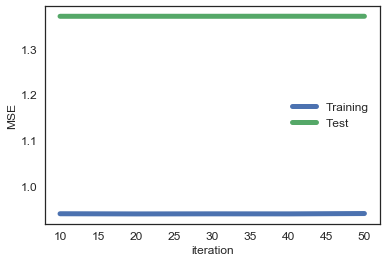

In [41]:
plt.plot([10,20,30,40,50], [i[0] for i in out], \
             label = 'Training', linewidth=5)
plt.plot([10,20,30,40,50], [i[1] for i in out], \
             label = 'Test', linewidth=5)

plt.xticks(fontsize = 12);
plt.yticks(fontsize = 12);
plt.xlabel('iteration', fontsize = 12);
plt.ylabel('MSE', fontsize = 12);
plt.legend(loc = 'best', fontsize = 12);

The MSE on the test set is almost flat along with the increment in iterations. Thus, we select 10 iterations when tuning the number of latent factors.

#### Tune Number of Latent Factors 

In [43]:
out2 = [ RecommendationALS(ratings = train_Ncore_user_normalized, 
                  n_factors = x,
                  item_reg = 2.0,
                  user_reg = 2.0,
                  max_iter = 10,
                  verbose = False).calculate_mse(test = test_Ncore_user_normalized) for x in [5,10,15,20,25]]

In [44]:
for i,v in enumerate([10,20,30,40,50]):
    print ("MSE on Training with ", v, " Latent Factors: {:4.6f}".format(out2[i][0]))
    print ("MSE on Test with ", v, " Latent Factors: {:4.6f}".format(out2[i][1]))

MSE on Training with  10  Latent Factors: 0.997097
MSE on Test with  10  Latent Factors: 1.370960
MSE on Training with  20  Latent Factors: 0.975287
MSE on Test with  20  Latent Factors: 1.370675
MSE on Training with  30  Latent Factors: 0.956182
MSE on Test with  30  Latent Factors: 1.370834
MSE on Training with  40  Latent Factors: 0.939384
MSE on Test with  40  Latent Factors: 1.370614
MSE on Training with  50  Latent Factors: 0.924504
MSE on Test with  50  Latent Factors: 1.370728


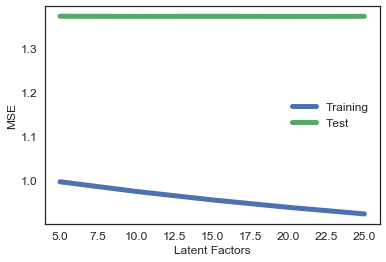

In [45]:
plt.plot([5,10,15,20,25], [i[0] for i in out2], \
             label = 'Training', linewidth=5)
plt.plot([5,10,15,20,25], [i[1] for i in out2], \
             label = 'Test', linewidth=5)

plt.xticks(fontsize = 12);
plt.yticks(fontsize = 12);
plt.xlabel('Latent Factors', fontsize = 12);
plt.ylabel('MSE', fontsize = 12);
plt.legend(loc = 'best', fontsize = 12);

According to the two graphs above, there is no significate improvement in MSE on the test set with change in the number of latent factors and iterations. The collaborative filter with alternating least square seems having worse performance than the baseline. This output might result from two caveats: (1) the user-item ratings training matrix is highly sparse (lower than 0.2% after split), which leads to too much randomness on the baseline MSE; (2) the training set is not normalized item-wisely.

### Latent Factorized Collaborative Filter By Stochastic Gradient Descent

We did three enhancement in the following Stochastic Gradient Descent Factorized Collaborative:<br>
* Add user bias and item bias to the model
* Apply mini-batch to updating the gradient descent
* Add pre cut-off on the iteration when percentage change on the MSE between epoches is lower than the threshold<br>

By adding user bias and item bias to the model, we re-write the loss function as
<br>
$$ \sum_{u,i}{(r_{u,i}-(\mu+b_u+b_i+x_u^{T}\cdot y_i))^{2}}+\lambda_{xb}\sum_{u}\lVert b_u\rVert^{2}+\lambda_{yb}\sum_{i}\lVert b_i\rVert^{2}+\lambda_{xf}\sum_{u}\lVert x_u\rVert^{2}+\lambda_{yf}\sum_{i}\lVert y_i\rVert^{2}  $$  

where $r_{u,i}$ is the actual ratings, $_{u}$, $_{i}$ and $_{f}$ are the number of users, items and latent factors, $ x_u$ and $y_i$ are the $_{u}$ $\times$ $_{f}$ latent factors matrix and $_{i}$ $\times$ $_{f}$ latent factor matrix, $b_u$ and $b_i$ are the user bias vector and the item bias vector in the length of $_{u}$ and $_{i}$ respectively, and $\lambda_{xb}, \lambda_{yb}, \lambda_{xf}$ and $\lambda_{yf} $ are the regularization terms applied on both latent factors and bias. $\mu$ is the global bias.
<br>
The following is the predicted rating of a user to a specific item:
$$\hat{r_{u,i}}= \mu+b_u+b_i+x_u^{T}\cdot y_i   $$   

Due to the user and item bias applied on the following model, we should load the non-normalized training data set into the Stochastic Gradient Descent Collaborative Filter and compute the MSE by subtracting the non-normalized test set from the prediction as well.

In [18]:
class RecommendationSGD_Random():
    
    def __init__(self, 
                 ratings, 
                 n_factors = 10, 
                 item_reg = 1.0, 
                 user_reg = 1.0,
                 item_bias_reg = 1.0,
                 user_bias_reg = 1.0,
                 max_iter = 15,
                 batch_size=3,
                 learning_rate = 0.01,
                 tolerance=0.0001,
                 verbose = True):
        """
        Train a matrix factorization model to predict empty 
        entries in a matrix. The terminology assumes a 
        ratings matrix which is ~ user x item
        
        Params
        ======
        ratings : (ndarray)
            User x Item matrix with corresponding ratings
        
        n_factors : (int)
            Number of latent factors to use in matrix 
            factorization model
        
        item_reg : (float)
            Regularization term for item latent factors
        
        user_reg : (float)
            Regularization term for user latent factors
        
        item_bias_reg : (float)
            Item bias for item latent factors, shape as number of items *1
        
        user_bias_reg : (float)
            User bias for user latent factors, shape as number of users *1
            
        max_iter: (int)
            Max number of epoch
        
        batch_size: (int)
            number of rows input each time to update the gradient
        
        learning_rate: (float)
            learning rate of latent factors and bias
        
        tolerance: (float)
            cut-off on iterations when percange change in loss function lower to the value
            
        verbose : (bool)
            Whether or not to printout training progress
        """
        
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.item_reg = item_reg
        self.user_reg = user_reg
        
        self.item_bias_reg = item_bias_reg
        self.user_bias_reg = user_bias_reg
        self.learning_rate = learning_rate
        self.sample_row, self.sample_col = self.ratings.nonzero()
        self.n_samples = len(self.sample_row)
        self.batch_size=batch_size
        self._v = verbose
        self.n_iter = max_iter
        self.MSE=[]
        self.tolerance=0-tolerance

    
    def fit(self):
        """ 
        Train model
        """       
        self.ratings_zero=np.zeros(self.ratings.shape)
        self.user_vecs = np.random.random((self.n_users, self.n_factors))
        self.item_vecs = np.random.random((self.n_items, self.n_factors))
        
        self.user_bias = np.zeros(self.n_users)
        self.item_bias = np.zeros(self.n_items)
        self.global_bias = np.mean(self.ratings[np.where(self.ratings != 0)])
        
        ctr = 1
        while ctr <= self.n_iter:
            if ctr % 10 == 0 :
                print ('\tcurrent iteration: {}'.format(ctr))
            
            if ctr>1:
                # predict the ratings by applying the vectorized prediction forluma
                ratings_pred=self.user_bias[:,np.newaxis]+self.item_bias[np.newaxis,:]+self.global_bias+self.user_vecs.dot(self.item_vecs.T)
                ratings_pred=np.nan_to_num(ratings_pred)
                
                self.MSE.append(get_mse(ratings_pred, self.ratings))
                if self._v:
                    print (self.MSE[-1])
            if len(self.MSE)>1:
                # set the tolerance on the difference in MSE, cut-off the iteration when the difference is less than tolerance
                if self.MSE[-1]<self.MSE[-2] and (self.MSE[-1]-self.MSE[-2])/self.MSE[-2]>self.tolerance:
                    return (self.user_vecs, self.item_vecs, self.user_bias, self.item_bias, self.global_bias)
            # one sample SGD
            self.training_indices = np.arange(self.n_samples)
            np.random.shuffle(self.training_indices)
            
            for start_idx in range(0, self.n_samples - self.batch_size + 1, self.batch_size):
                idx = self.training_indices[start_idx:start_idx + self.batch_size]
                u = self.sample_row[idx]
                i = self.sample_col[idx]
                
                # error
                e = [self.ratings[a,b] - self.predict(a,b) for a,b in zip(u,i)]
                
                # update biases
                self.user_bias[u] += self.learning_rate * (e - self.user_bias_reg * self.user_bias[u])
                self.item_bias[i] += self.learning_rate * (e - self.item_bias_reg * self.item_bias[i])
                
                # update latent factors
                self.user_vecs[u, :] = [self.user_vecs[u, :][x] + self.learning_rate * (e[x] * self.item_vecs[i, :][x] - self.user_reg * self.user_vecs[u,:][x]) for x in range(self.batch_size)]          
                self.item_vecs[i, :] = [self.item_vecs[i, :][x] + self.learning_rate * (e[x] * self.user_vecs[u, :][x] - self.item_reg * self.item_vecs[i,:][x]) for x in range(self.batch_size)]
                
            ctr += 1
        
        
        return (self.user_vecs, self.item_vecs, self.user_bias, self.item_bias, self.global_bias)
    
    def predict(self, u, i):
        prediction = self.global_bias + self.user_bias[u] + self.item_bias[i]
        prediction += self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
        prediction=np.nan_to_num(prediction)
        return prediction
    
    def get_prediction(self):
        vecs = self.fit()
        user_vecs = vecs[0]
        item_vecs = vecs[1]
        user_bias = vecs[2]
        item_bias = vecs[3]
        global_bias = vecs[4]
        predictions=user_bias[:,np.newaxis]+item_bias[np.newaxis,:]+global_bias+user_vecs.dot(item_vecs.T)
        return predictions
    

#### Tune Epoch

In [48]:
SGD1=[RecommendationSGD_Random(train_Ncore_user,n_factors = 10,max_iter= x,
                 batch_size=50) for x in [10,20,30,40,50]]

In [49]:
SGD_Pred1=[x.get_prediction() for x in SGD1]

1.77318169575
1.23166861169
1.05099926704
0.968663731447
0.926090870292
0.901682136273
0.885491408177
0.875460417908
	current iteration: 10
0.868497915535
1.78675732653
1.23714299141
1.05246211254
0.969993624444
0.926473207497
0.901073446389
0.88527087582
0.875374022133
	current iteration: 10
0.867564929198
0.863709322381
0.860029999467
0.857018663059
0.854964009512
0.853807175453
0.852808713334
0.851690287318
0.850958029563
0.850906683229
1.78021895432
1.23467447212
1.05234223705
0.969845817162
0.926494795829
0.901321971177
0.885392695378
0.875301075156
	current iteration: 10
0.868380861673
0.863194052971
0.859918302066
0.85723841905
0.85485001509
0.853754798898
0.852850692029
0.851790822016
0.850882322535
0.850776524178
	current iteration: 20
0.850341684286
0.849809598683
0.849493321385
0.849658042288
0.849318148634
0.849522283965
0.849961441475
0.849734018008
0.85001650372
0.850210806676
	current iteration: 30
0.84979997437
1.79024876018
1.24074444935
1.05439242947
0.971698233
0.928

In [52]:
for i,v in enumerate([10,20,30,40,50]):
    print ("MSE on Training with ", v, " Iterations: {:4.6f}".format(get_mse(SGD_Pred1[i],train_Ncore_user)))
    print ("MSE on Test with ", v, " Iterations: {:4.6f}".format(get_mse(SGD_Pred1[i],test_Ncore_user)))
   

MSE on Training with  10  Iterations: 0.864009
MSE on Test with  10  Iterations: 1.163698
MSE on Training with  20  Iterations: 0.850907
MSE on Test with  20  Iterations: 1.131324
MSE on Training with  30  Iterations: 0.850256
MSE on Test with  30  Iterations: 1.125190
MSE on Training with  40  Iterations: 0.850871
MSE on Test with  40  Iterations: 1.130312
MSE on Training with  50  Iterations: 0.849987
MSE on Test with  50  Iterations: 1.128205


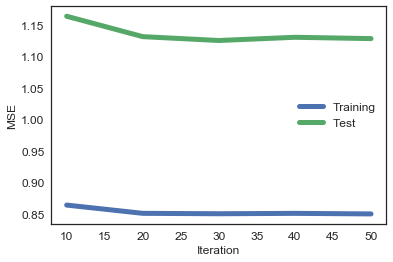

In [53]:
plt.plot([10,20,30,40,50], [get_mse(i,train_Ncore_user) for i in SGD_Pred1], \
             label = 'Training', linewidth=5)
plt.plot([10,20,30,40,50], [get_mse(i,test_Ncore_user) for i in SGD_Pred1], \
             label = 'Test', linewidth=5)

plt.xticks(fontsize = 12);
plt.yticks(fontsize = 12);
plt.xlabel('Iteration', fontsize = 12);
plt.ylabel('MSE', fontsize = 12);
plt.legend(loc = 'best', fontsize = 12);

At the number of latent factor as 10, biggest drop on MSE of the test set occurs between the epochs from 10 to 20. Although MSE reached the lowest at 30 epochs, the difference in MSEs from epoch 20 to 50 don't change too much. Besides, the trainings on Collaborative Filters with 40 and 50 epochs both expirence cut-offs after 20 more iterations. Thus, we select 20 epochs as the number of epoch to optimize both the efficiency in tuning other parameters and the accuracy.

#### Tune Number of Latent Factors 

In [236]:
SGD2=[RecommendationSGD_Random(train_Ncore_user,max_iter = 20,n_factors = x,
                 batch_size=50) for x in [5,10,20,25,30]]

In [237]:
SGD_Pred2=[x.get_prediction() for x in SGD2]

1.32440332188
1.09768500404
1.0080939053
0.961150281606
0.933579204546
0.915754976178
0.903090342141
0.894114981536
	current iteration: 10
0.887363371463
0.882206859413
0.878071556904
0.875121848202
0.872266807709
0.870117189202
0.86813651555
0.866220434394
0.864886191184
0.863325842028
	current iteration: 20
0.862803307537
1.77536520313
1.23266415854
1.04993403956
0.96813749268
0.925600360341
0.900657710932
0.884547784318
0.874457147068
	current iteration: 10
0.867586253859
0.862874516287
0.859749710897
0.856778266081
0.854870418785
0.853578486446
0.852746536483
0.851096073412
0.851126603112
0.850587988764
	current iteration: 20
0.850552892644
2.74020608834
1.47987919306
1.11903605554
0.975692677093
0.907887406033
0.873346778096
0.8533230513
0.841845133944
	current iteration: 10
0.835380073211
0.831044519369
0.828597246446
0.826931451391
0.826666711847
0.826215355786
0.82648612773
0.826624379116
0.827491036776
0.828625639077
	current iteration: 20
0.829278487611
3.17124716999
1.574663

In [238]:
for i,v in enumerate([5,10,20,25,30]):
    print ("MSE on Training with ", v, " Latent Factors: ",get_mse(SGD_Pred2[i],train_Ncore_user))
    print ("MSE on Test with ", v, " Latent Factors: ",get_mse(SGD_Pred2[i],test_Ncore_user))

MSE on Training with  5  Latent Factors:  0.861936460172
MSE on Test with  5  Latent Factors:  1.12752300633
MSE on Training with  10  Latent Factors:  0.850552892644
MSE on Test with  10  Latent Factors:  1.13191113069
MSE on Training with  20  Latent Factors:  0.829780465649
MSE on Test with  20  Latent Factors:  1.14893670239
MSE on Training with  25  Latent Factors:  0.821514888452
MSE on Test with  25  Latent Factors:  1.15673135994
MSE on Training with  30  Latent Factors:  0.812650501339
MSE on Test with  30  Latent Factors:  1.16749595385


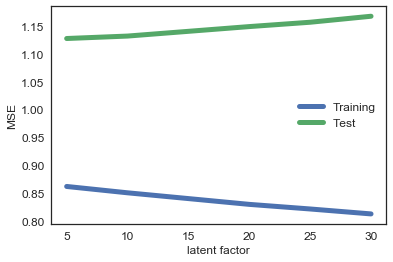

In [239]:
plt.plot([5,10,20,25,30], [get_mse(i,train_Ncore_user) for i in SGD_Pred2], \
             label = 'Training', linewidth=5)
plt.plot([5,10,20,25,30], [get_mse(i,test_Ncore_user) for i in SGD_Pred2], \
             label = 'Test', linewidth=5)

plt.xticks(fontsize = 12);
plt.yticks(fontsize = 12);
plt.xlabel('latent factor', fontsize = 12);
plt.ylabel('MSE', fontsize = 12);
plt.legend(loc = 'best', fontsize = 12);

Under 20 epoches for each combination of N factors, the model overfits the training set along with the increase in number of factors. Thus, 5 latent factors are selected since the MSE of the test set reaches the lowest at this point.<br>
The MSE of the Latenet Factorized Collaborative Filter trainied by Stochastic Gradient Descent is obvisouly lower than the baseline. We will recommend top N ranked items by the predicted ratings from this filter in the following recommendation system. 

In [19]:
SGD2=[RecommendationSGD_Random(train_Ncore_user,max_iter = 20,n_factors = x,
                 batch_size=50,verbose=False) for x in [5]]
SGD_Pred2=[x.get_prediction() for x in SGD2]

	current iteration: 10
	current iteration: 20


In [20]:
get_mse(SGD_Pred2[0],test_Ncore_user)

1.1211664005270885

## Recommendation With Item Details

To evaluate prediction of the collaborative filter really make sense or not, we decide to check the output in a more intuitive way by comparing what the system recommended with what the user's already rated. For this comparison, information other than asin (product ID) such as item name, description on the item and the category where the item belongs to is required.<br>
These information is stored in __meta_Beauty.json__. In the recommendation system, the asin of the top recommended items are linked back to the meta data to extract those details.

### Read-In Product Meta Data

In [21]:
meta_original = getDF('meta_Beauty.json')

In [22]:
meta=copy.deepcopy(meta_original)
for i in range(4):
    meta['type_L'+str(i)] = meta['categories'].apply(lambda x: x[0][i] if i<len(x[0]) else np.nan)
item_category=pd.DataFrame(meta.groupby(['type_L0', 'type_L1', 'type_L2', 'type_L3'])['asin'].nunique()).reset_index()

In [35]:
meta.columns

Index(['imUrl', 'description', 'asin', 'salesRank', 'title', 'categories',
       'price', 'related', 'brand', 'type_L0', 'type_L1', 'type_L2',
       'type_L3'],
      dtype='object')

In [6]:
meta.groupby(['type_L0', 'type_L1', 'type_L2', 'type_L3']).asin.nunique().to_frame()

asin
type_L0                type_L1                     type_L2                      type_L3                                 
Beauty                 Bath & Body                 Bath                         Bath Bombs                           254
                                                                                Bath Pearls & Flakes                  33
                                                                                Bubble Bath                          516
                                                                                Minerals & Salts                     791
                                                                                Oils                                 295
                                                                                Tub Tea                               26
                                                   Bathing Accessories          Bath Brushes                         301
                                                                                Bath Mitts & Cloths                  296
                                                                                Bath Pillows                         177
                                                                                Bath Trays                            69
                                                                                Eye Masks                             52
                                                                                Loofahs, Sponges & Poufs             597
                                                                                Shower Caps                          403
                                                   Cleansers                    Body Washes                         4918
                                                                                Soaps                               6238
                                                   Scrubs & Body Treatments     Body Mud                             219
                                                                                Body Scrubs                         3340
                                                                                Body Souffles & Mousse               149
                       Fragrance                   Men's                        Cologne                             1763
                                                                                Eau de Parfum                        304
                                                                                Eau de Toilette                     3567
                                                                                Sets                                1105
                                                   Women's                      Body Sprays                         1153
                                                                                Cologne                              925
                                                                                Eau de Parfum                       7523
                                                                                Eau de Toilette                     4480
                                                                                Essential Oils                       674
                                                                                Sets                                2098
                       Hair Care                   Hair Color                   Chemical Hair Dyes                  3438
                                                                                Color Correctors                      75
...                                                                                                                  ...
                       Tools & Accessories         Hair Coloring Tools          Hair Color Removers                   31
  

According to the table above, a three-layer category has been sufficient for us to understand the purpose of a product. Those three categories would be presented in the following function telling what kind of product the user has rated.

In [23]:
def Advanced_Recommendation(Pred,ratings_Ncore,User,N):
    user_in_list=user_map_afterNcore.ix[user_map_afterNcore['reviewerID']==User,'reviewerID_Ncore']
    if pd.notnull(user_in_list.values[0]):
        Pred_C=copy.deepcopy(Pred)
        #replace all the item rated by users as zero to avoid recommend item user already bought
        Pred_C[np.where(ratings_Ncore!=0)[0],np.where(ratings_Ncore!=0)[1]]=0
        #find what the user has rated
        item_bought=np.nonzero(ratings_Ncore[int(user_in_list.values[0]),:])[0].tolist()
        asin_bought=item_map_afterNcore.loc[item_map_afterNcore['asinID_Ncore'].isin(item_bought),'asin'].tolist()
        category_bought=meta.loc[meta['asin'].isin(asin_bought),['type_L1','type_L2','type_L3','asin']]
        category_bought_df=category_bought.groupby(['type_L1','type_L2','type_L3'])['asin'].nunique().to_frame().reset_index()\
        .sort_values(by='asin',ascending=False)
        total=np.sum(category_bought_df['asin'])
        category_bought_df['precent']=category_bought_df['asin']/total
        category_bought_df['precent']=category_bought_df['precent'].apply(lambda x: "{0:.0%}".format(x))
        print ('items bought')
        print(category_bought_df[['type_L1','type_L2','type_L3','asin','precent']])
        #recommend items
        item_Ncore=np.argsort(Pred_C[int(user_in_list.values[0]),:])[:-N-1:-1].tolist()
        Recommend=item_map_afterNcore.loc[item_map_afterNcore['asinID_Ncore'].isin(item_Ncore),'asin'].tolist()
        print ("\n items recommended")
        return  meta.loc[meta['asin'].isin(Recommend),['asin','title','type_L1','type_L2','type_L3','description','imUrl']]
    else:
        print ('Too few items bought to predict')
        return False

Let's select reviewer 'AZXP46IB63PU8' to predict what top ten items the system recommends and compare with items he/she rated.

In [27]:
Advanced_Recommendation(SGD_Pred2[0],ratings_Ncore,User='AZXP46IB63PU8',N=10)

items bought
       type_L1 type_L2                type_L3  asin precent
2    Skin Care    Face  Creams & Moisturizers     4     50%
1    Skin Care    Body           Moisturizers     2     25%
0  Bath & Body    Bath            Bubble Bath     1     12%
3    Skin Care    Face          Oils & Serums     1     12%

 items recommended


,asin,title,type_L1,type_L2,type_L3,description,imUrl
5168,B00027CGWQ,"Udderly Smooth Udder Cream, Skin Moisturizer, ...",Skin Care,Body,Moisturizers,Udderly SMooth Udder Cream is a water-based m...,http://ecx.images-amazon.com/images/I/51fm2Lcc...
16778,B000F8FZAC,Moisturizer-Almond Aloe With SPF15 Earth Scien...,Skin Care,Face,Creams & Moisturizers,Moisturizer-Almond Aloe With SPF15 by Earth Sc...,http://ecx.images-amazon.com/images/I/31lPlx89...
16946,B000FCNW26,"Obsession Night by Calvin Klein for Women, Eau...",Fragrance,Women's,Eau de Parfum,Obsession Night by Calvin Klein designer fragr...,http://ecx.images-amazon.com/images/I/41noHh7L...
77207,B002BPY7H4,Doo Gro Stimulating Growth Oil,Skin Care,Body,Moisturizers,Doo Gro Stimulating Growth Oil promotes strong...,http://ecx.images-amazon.com/images/I/31f1rOgN...
78633,B002E788WE,PedEgg Original Foot File,Tools & Accessories,Nail Tools,Foot Rasps,"As seen on TV. Gently removes callous, dry ski...",http://ecx.images-amazon.com/images/I/41y7NRKu...
100230,B003H87S0C,Dr. Dennis Gross Skincare Original Formula Alp...,Skin Care,Face,Treatments & Masks,Specifically proven results can only be achiev...,http://ecx.images-amazon.com/images/I/41E4YoTR...
100260,B003HD04DK,Formula 10.0.6 Totally Clean Cleanser Original...,Skin Care,Face,Treatments & Masks,Formula 10.0.6 Totally Clean Cleanser Original...,http://ecx.images-amazon.com/images/I/31TlfovW...
103444,B003MTPE5M,Gratiae Organics Ultrox Expression Marks Anti ...,Skin Care,Face,Creams & Moisturizers,The GRATiAE Organic Ultrox Expression Marks An...,http://ecx.images-amazon.com/images/I/41iJrrxo...
117230,B004A7VG70,"Olay Cleansing Body Wash, Silky Berry, 23.6 Fl...",Bath & Body,Cleansers,Body Washes,,http://ecx.images-amazon.com/images/I/412Zmdgj...
201912,B00A7FS2OO,DNS Biogenesis Eye Roller-vessel Sealing Syste...,Skin Care,Eyes,Rollers & Pens,"At bioGenesis London, our skin scientists are ...",http://ecx.images-amazon.com/images/I/41qhgSgh...


In [33]:
# check for the details about what the user has rated
df.loc[df['reviewerID']=='AZXP46IB63PU8'].merge(meta, how='left',on='asin')[["reviewText","reviewerID",\
                                                                             "asin","overall","title",\
                                                                             "type_L1","type_L2","type_L3"]]

,reviewText,reviewerID,asin,overall,title,type_L1,type_L2,type_L3
0,I did 't have a reaction to this cream which i...,AZXP46IB63PU8,B0007W1R58,5.0,Olay Regenerist Night Recovery Cream 1.7 Oz,Skin Care,Body,Moisturizers
1,I purchased this because I bought the day crea...,AZXP46IB63PU8,B000KPO99I,5.0,"L'Oreal Paris Age Perfect Night Cream, 2.5 Flu...",Skin Care,Face,Creams & Moisturizers
2,I use this every day. It's a light face cream...,AZXP46IB63PU8,B000UVZU1S,5.0,"St. Ives Facial Moisturizer, Timeless Skin Col...",Skin Care,Face,Creams & Moisturizers
3,My face is very dry and flakey. This cream ke...,AZXP46IB63PU8,B0012J30LY,5.0,Regenerist Micro-Sculpting Cream 1.7 Oz,Skin Care,Face,Creams & Moisturizers
4,I have diabetic never pain and was looking for...,AZXP46IB63PU8,B0043494XS,5.0,"Conair Waterfall Foot Spa with Lights, Bubbles...",Bath & Body,Bath,Bubble Bath
5,Really great skin cream. I bought it because ...,AZXP46IB63PU8,B004YWRYUY,5.0,L'oreal Age Perfect Day Cream SPF 15 2.5 Oz,Skin Care,Face,Creams & Moisturizers
6,A really great skin fluid. I like it even mor...,AZXP46IB63PU8,B005H1541C,5.0,L'Oreal Paris Age Perfect Hydra-Nutrition Adva...,Skin Care,Face,Oils & Serums
7,"If you have dry skin for whatever reason, this...",AZXP46IB63PU8,B00AHH00TC,5.0,"Gold Bond Diabetic Skin Relief Lotion, 13 Ounce",Skin Care,Body,Moisturizers


According to the table above, most items this user rated are anti-aging products, which indicates his/her age might be over fourty fifty. He/She also bought foot care, which indicates this user might be focus on detail parts of his/her body.<br>
Anti-wrinkle and anti-oxidants products with asin ID as "B003MTPE5M" and "B003H87S0C" are amongst the top 10 items recommended to the customer. These items are most related to the anti-aging products the customer cares about. Besides, this customer has a dry skin according to his/her reviews. The body wash product 'B004A7VG70' also provide extra moisture to skin.<br>
<br/>
___Note___: Since the collborative filter recommends products to customer bought at least 8 items and pops out 3 items rated by each customer into test set at the beginning, there is much more randomness in the recommended items to customers who rated few number of items. For instance, the customer analyzed above rated 6 anti-aging products and 2 others. With the random split on the item rated into training and test, the combination of 5 anti-aging products in the training set versus the combination of 3 anti-aging products and 2 other products would lead to a very different prediction for this customer. The randomness in recommended items is derived from the high sparsity of the overall user-item rating matrix. And, too many sample would be dropped if we take an aggressive lift the threshold on number of items rated by users in the N-core matrix.



In [38]:
meta.loc[meta['asin']=="B000F8FZAC",["title"]].values

array([['Moisturizer-Almond Aloe With SPF15 Earth Science 5 oz Cream']], dtype=object)